In [1]:
import torch
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import functools
from diffusers import DDPMPipeline
from dataclasses import dataclass
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
cache_dir = '/Data/dheurtel/cache'

/users/eleves-a/2020/david.heurtel-depeiges/Desktop/ALTeGraD23_Data_Challenge/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tracing = False
half = True

if half:
    torch.set_default_tensor_type(torch.HalfTensor)

In [3]:
model_name="google/ddpm-ema-celebahq-256" # 256x256 8 iteratons/second
model_name="basilevh/ddpm-ema-flowers-256-noac"

ddpm = DDPMPipeline.from_pretrained(model_name, cache_dir=cache_dir,torch_dtype=torch.float16).to(device)
ddpm.unet.eval()

checkpoint-21000/model.safetensors not found
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]


UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsampl

In [4]:
from pathlib import Path
import datasets
from datasets import load_dataset
datasets.config.DOWNLOADED_DATASETS_PATH = Path("/Data/datasets")
dataset = load_dataset("huggan/flowers-102-categories", cache_dir=cache_dir, split="train")

In [5]:
@dataclass
class UNet2DConditionOutput:
    sample: torch.FloatTensor

if tracing:
    raise NotImplementedError("Tracing not implemented")
    torch.set_grad_enabled(False)
    # set variables
    unet = ddpm.unet
    unet.eval()
    unet.forward = functools.partial(unet.forward, return_dict=False)
    def generate_input():
        return torch.randn(10, 3, 256, 256, device=device), torch.randint(0,999, (10,), device=device)

    # warmup
    for _ in range(10):
        inputs = generate_input()
        output = unet(*inputs)
    print("tracing..")
    unet_traced = torch.jit.trace(unet, inputs)
    unet_traced.eval()
    print("done tracing")

    class TracedUNet(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.in_channels = unet.config.in_channels
            self.device = unet.device
            self.dtype = unet.dtype
            self.config = unet.config
            self.traced = unet_traced

        def forward(self, model_input, t):
            sample = self.traced(model_input, t)[0]
            return UNet2DConditionOutput(sample=sample)

    traced_unet = TracedUNet().to(device)
    ddpm.unet = traced_unet


100%|██████████| 1000/1000 [00:23<00:00, 42.95it/s]


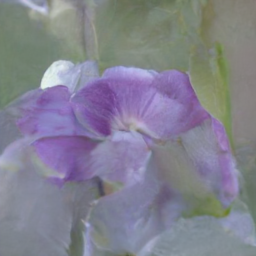

In [6]:
image = ddpm(num_inference_steps=1000).images[0]
image

In [7]:
scheduler = ddpm.scheduler
model = ddpm.unet

In [8]:
num_time_steps = 200

scheduler.set_timesteps(num_time_steps)

In [9]:
scheduler.alphas_cumprod

tensor([9.9990e-01, 9.9978e-01, 9.9964e-01, 9.9948e-01, 9.9930e-01, 9.9910e-01,
        9.9888e-01, 9.9864e-01, 9.9838e-01, 9.9811e-01, 9.9781e-01, 9.9749e-01,
        9.9715e-01, 9.9679e-01, 9.9641e-01, 9.9602e-01, 9.9560e-01, 9.9516e-01,
        9.9471e-01, 9.9423e-01, 9.9374e-01, 9.9322e-01, 9.9269e-01, 9.9213e-01,
        9.9156e-01, 9.9097e-01, 9.9035e-01, 9.8972e-01, 9.8907e-01, 9.8840e-01,
        9.8771e-01, 9.8700e-01, 9.8627e-01, 9.8553e-01, 9.8476e-01, 9.8398e-01,
        9.8317e-01, 9.8235e-01, 9.8151e-01, 9.8065e-01, 9.7977e-01, 9.7887e-01,
        9.7795e-01, 9.7702e-01, 9.7606e-01, 9.7509e-01, 9.7410e-01, 9.7309e-01,
        9.7206e-01, 9.7102e-01, 9.6995e-01, 9.6887e-01, 9.6777e-01, 9.6665e-01,
        9.6551e-01, 9.6436e-01, 9.6319e-01, 9.6200e-01, 9.6079e-01, 9.5956e-01,
        9.5832e-01, 9.5706e-01, 9.5578e-01, 9.5449e-01, 9.5318e-01, 9.5185e-01,
        9.5050e-01, 9.4914e-01, 9.4776e-01, 9.4636e-01, 9.4494e-01, 9.4351e-01,
        9.4207e-01, 9.4060e-01, 9.3912e-

In [10]:
def scheduler_alpha_t(scheduler, t):
    # Get \bar\alpha_t and \alpha_t from scheduler
    #   t should be an integer between 0 and T
    #   T = scheduler.num_train_timesteps # 1000
    prev_t = scheduler.previous_timestep(t)
    alpha_prod_t = scheduler.alphas_cumprod[t]
    alpha_prod_t_prev = scheduler.alphas_cumprod[prev_t] if prev_t >= 0 else scheduler.one
    #beta_prod_t = 1 - alpha_prod_t
    #beta_prod_t_prev = 1 - alpha_prod_t_prev
    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    #current_beta_t = 1 - current_alpha_t
    return alpha_prod_t, current_alpha_t

def scheduler_alphas(scheduler):
    T = scheduler.num_inference_steps # 1000
    stride=1
    n = T #math.ceil((T+1)/stride)
    alpha = torch.zeros(n)
    alpha_bar = torch.zeros(n)
    time = torch.zeros(n)
    for t in range(0,T,stride):
        alpha_prod_t, current_alpha_t = scheduler_alpha_t(scheduler, t)
        #beta_prod_t = 1 - alpha_prod_t
        #current_beta_t = 1 - current_alpha_t
        #bt = current_beta_t / torch.sqrt(current_alpha_t)
        alpha[t] = current_alpha_t
        alpha_bar[t] = alpha_prod_t
        time[t] = t
    return alpha, alpha_bar, time

200


/users/eleves-a/2020/david.heurtel-depeiges/Desktop/ALTeGraD23_Data_Challenge/venv/lib64/python3.9/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


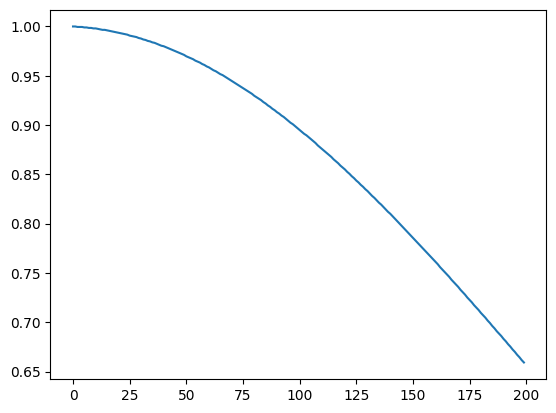

In [11]:
# T = number of timesteps during training
T = scheduler.num_train_timesteps # 1000

# TI = number of timesteps during inference
TI = T
scheduler.set_timesteps(200)
print(scheduler.num_inference_steps)

# Get variance schedule
alpha, alpha_bar, time = scheduler_alphas(scheduler)

# Plot variance schedule
plt.plot(time, alpha_bar, label="alpha_bar")


In [12]:
from utils.motionblur import Kernel
from utils.utils_img import fft_blur, clean_output

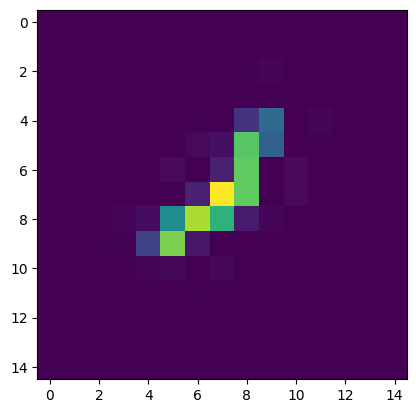

In [13]:
kernel = Kernel(size=(15,15), intensity=0.5)

plt.imshow(kernel.kernelMatrix)

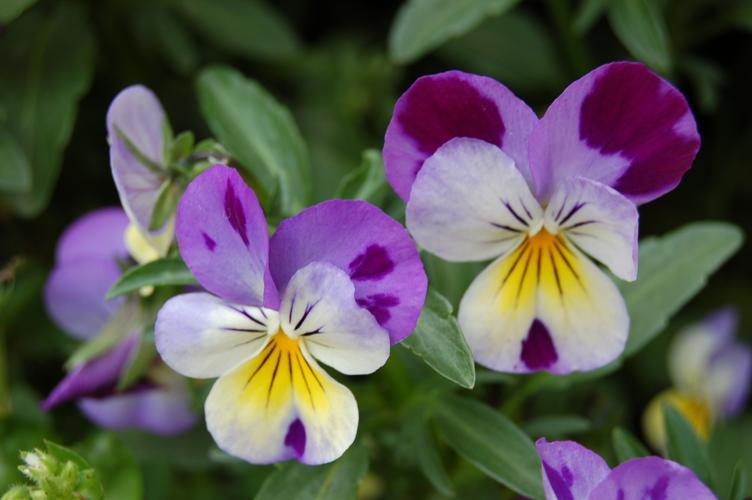

In [14]:
## Img from PIL to torch
pil_img = dataset[0]["image"]
pil_img

In [15]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [16]:
img = transform(pil_img)
img.shape

k = torch.tensor(kernel.kernelMatrix)

In [17]:
sigma_y = 0.03

In [18]:
blurry_img = fft_blur(img.to(torch.float32), k.unsqueeze(0).unsqueeze(0)).to(torch.float16) + sigma_y*torch.randn_like(img)

In [19]:
def clamp(tensor, min_val, max_val):
    return torch.max(torch.min(tensor, max_val*torch.ones_like(tensor)), min_val*torch.ones_like(tensor))

In [20]:
def clean_output(x):
    return (clamp(x, -1, 1)+1)/2

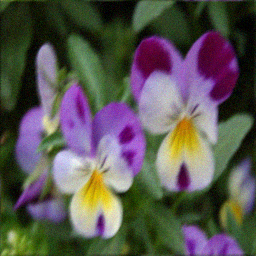

In [21]:
pil_blurry_img = transforms.ToPILImage()(clamp(blurry_img[0], 0., 1.))
pil_blurry_img

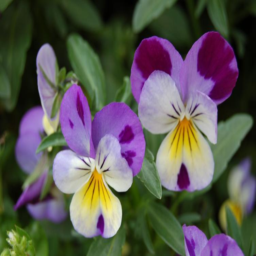

In [22]:
pil_img = transforms.ToPILImage()(img)
pil_img

In [23]:
def alpha_beta(scheduler, t):
    prev_t = scheduler.previous_timestep(t)
    alpha_prod_t = scheduler.alphas_cumprod[t]
    alpha_prod_t_prev = scheduler.alphas_cumprod[prev_t] if prev_t >= 0 else scheduler.one
    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    current_beta_t = 1 - current_alpha_t
    return current_alpha_t, current_beta_t

In [33]:

# DPS with DDPM and intrinsic scale
def dps_sampling(model, scheduler, y, forward_model, nsamples=1, scale=1, scale_guidance=1):
    sample_size = model.config.sample_size
    for param in model.parameters():
        param.requires_grad = False
    # Init random noise
    x_T = torch.randn((nsamples, 3, sample_size, sample_size)).to(device)
    x_t = x_T
    count = 0
    length = len(scheduler.timesteps)
    print_every = length // 10
    for t in tqdm.tqdm(scheduler.timesteps):
        
        # Predict noisy residual eps_theta(x_t)
        x_t.requires_grad_()
        epsilon_t = model(x_t, t).sample

        # Get x0_hat and unconditional 
        # x_{t-1} = a_t * x_t + b_t * epsilon(x_t) + sigma_t z_t
        # with b_t = eta_t
        predict = scheduler.step(epsilon_t, t, x_t) 
        x0_hat  = clean_output(predict.pred_original_sample)
        x_prev  = predict.prev_sample # unconditional DDPM sample x_{t-1}'
        alpha_t, beta_t= alpha_beta(scheduler, t)
        # Guidance
        f = torch.norm(forward_model(x0_hat) - y)**2/2#/(sigma_y**2+
        g = torch.autograd.grad(f, x_t)[0]
        print(g.dtype)
        # compute variance schedule
        

        # Guidance weight
        # eta_t = ...
        if (scale_guidance==1):
            eta_t =  beta_t / torch.sqrt(alpha_t)
        else:
            eta_t = 1.0

        # DPS update rule = DDPM update rule + guidance
        x_t = x_prev - scale * eta_t * g
        x_t = x_t.detach_()

        if False and count % print_every == 0:
            # Show progress of the sampling
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(util.tensor2uint(x_t[0]))
            ax[0].axis('off')
            ax[0].set_title('t = %d' % t)
            ax[1].imshow(util.tensor2uint(x0_hat[0]))
            ax[1].axis('off')
            ax[1].set_title('t = %d' % t)
            plt.show()
        count += 1

    return clean_output(x_t)

In [34]:
forward_model = lambda x: fft_blur(x.to(torch.float32), k.unsqueeze(0).unsqueeze(0).to(x.device)).to(torch.float16) 

In [35]:
model = model.to(device)

In [36]:
res = dps_sampling(model, scheduler, blurry_img.to(device), forward_model, nsamples=1, scale=1, scale_guidance=1)

  0%|          | 0/200 [00:00<?, ?it/s]

  2%|▏         | 3/200 [00:00<00:08, 23.04it/s]

torch.float16
torch.float16
torch.float16
torch.float16
torch.float16


  4%|▍         | 9/200 [00:00<00:08, 22.86it/s]

torch.float16
torch.float16
torch.float16
torch.float16
torch.float16


  8%|▊         | 15/200 [00:00<00:08, 22.95it/s]

torch.float16
torch.float16
torch.float16
torch.float16
torch.float16


  9%|▉         | 18/200 [00:00<00:07, 23.00it/s]

torch.float16
torch.float16
torch.float16
torch.float16
torch.float16


 12%|█▏        | 24/200 [00:01<00:07, 23.00it/s]

torch.float16
torch.float16
torch.float16
torch.float16
torch.float16


 15%|█▌        | 30/200 [00:01<00:07, 23.05it/s]

torch.float16
torch.float16
torch.float16
torch.float16
torch.float16


 16%|█▋        | 33/200 [00:01<00:07, 23.04it/s]

torch.float16
torch.float16
torch.float16
torch.float16
torch.float16


 20%|█▉        | 39/200 [00:01<00:06, 23.05it/s]

torch.float16
torch.float16
torch.float16
torch.float16
torch.float16


 22%|██▎       | 45/200 [00:01<00:06, 23.06it/s]

torch.float16
torch.float16
torch.float16
torch.float16
torch.float16


 24%|██▍       | 48/200 [00:02<00:06, 23.04it/s]

torch.float16
torch.float16
torch.float16
torch.float16
torch.float16


 27%|██▋       | 54/200 [00:02<00:06, 22.99it/s]

torch.float16
torch.float16
torch.float16
torch.float16
torch.float16


 30%|███       | 60/200 [00:02<00:06, 22.97it/s]

torch.float16
torch.float16
torch.float16
torch.float16
torch.float16


 30%|███       | 61/200 [00:02<00:06, 22.62it/s]


torch.float16


KeyboardInterrupt: 

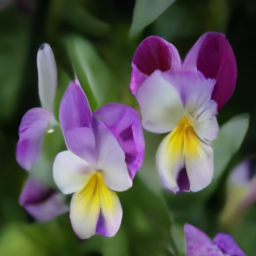

In [28]:
pil_res = transforms.ToPILImage()(res[0])
pil_res